# UAS CV

In [7]:
!git clone https://gitlab.com/ykristian/fg-net-dataset

Cloning into 'fg-net-dataset'...
Updating files:  34% (699/2004)
Updating files:  35% (702/2004)
Updating files:  36% (722/2004)
Updating files:  37% (742/2004)
Updating files:  38% (762/2004)
Updating files:  39% (782/2004)
Updating files:  40% (802/2004)
Updating files:  41% (822/2004)
Updating files:  42% (842/2004)
Updating files:  43% (862/2004)
Updating files:  44% (882/2004)
Updating files:  45% (902/2004)
Updating files:  46% (922/2004)
Updating files:  47% (942/2004)
Updating files:  48% (962/2004)
Updating files:  49% (982/2004)
Updating files:  50% (1002/2004)
Updating files:  51% (1023/2004)
Updating files:  52% (1043/2004)
Updating files:  53% (1063/2004)
Updating files:  54% (1083/2004)
Updating files:  55% (1103/2004)
Updating files:  56% (1123/2004)
Updating files:  57% (1143/2004)
Updating files:  58% (1163/2004)
Updating files:  59% (1183/2004)
Updating files:  60% (1203/2004)
Updating files:  61% (1223/2004)
Updating files:  62% (1243/2004)
Updating files:  63% (1263

In [1]:
url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
import requests

r = requests.get(url, stream=True)
with open('haarcascade.xml', 'w') as f:
    f.write(r.text)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# image augmentation
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.batches import UnnormalizedBatch

import dlib

import keras
import os
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization

In [13]:
# change this current directory to your directory
os.chdir('C:\\Users\\james\\Desktop\\J\\Kuliah\\Semester 6\\CV\\Latihan UAS\\age-estimation')
os.getcwd() 
%ls

 Volume in drive C is Windows-SSD
 Volume Serial Number is CA14-7644

 Directory of C:\Users\james\Desktop\J\Kuliah\Semester 6\CV\Latihan UAS\age-estimation

05/10/2021  03:53 PM    <DIR>          .
05/10/2021  03:53 PM    <DIR>          ..
05/10/2021  03:57 PM             1,959 .gitignore
05/10/2021  02:55 AM    <DIR>          .vscode
05/10/2021  04:15 PM           136,357 app.ipynb
05/10/2021  02:02 PM    <DIR>          fg-net-dataset
05/10/2021  04:48 PM           963,441 haarcascade.xml
05/10/2021  03:50 PM             1,086 LICENSE
05/10/2021  03:50 PM                16 README.md
               5 File(s)      1,102,859 bytes
               4 Dir(s)  201,320,144,896 bytes free


In [8]:
from keras_vggface.vggface import VGGFace
from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace

# Convolution Features
vgg_features = VGGFace(include_top=False, input_shape=(200, 200, 3), pooling='avg') # pooling: None, avg or max
for m in vgg_features.layers:
  m.trainable = False
# After this point you can use your model to predict.
# ...
vgg_features.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 200, 200, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 200, 200, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 100, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 100, 100, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 100, 100, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 50, 128)     

In [9]:
model = Sequential()
model.add(vgg_features)
model.add(Dense(20, activation='relu'))
model.add(Dense(1)) # 1 target class --> treat as regression
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_vgg16 (Functional)   (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 20)                10260     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 14,724,969
Trainable params: 10,281
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
def read_pts(filename):
    return np.loadtxt(filename, comments=("version:", "n_points:", "{", "}"))

In [95]:
os.chdir('C:\\Users\\james\\Desktop\\J\\Kuliah\\Semester 6\\CV\\Latihan UAS\\age-estimation')
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks_GTX.dat')

In [101]:
os.chdir('C:\\Users\\james\\Desktop\\J\\Kuliah\\Semester 6\\CV\\Latihan UAS\\age-estimation\\fg-net-dataset')

imgs_bgr = []
imgs_rgb = []
imgs_gray = []
for file in os.listdir():
    imgs_bgr .append(cv2.imread('images/001A02.JPG'))
    imgs_rgb .append(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    imgs_gray.append( cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY))

['001A02.JPG', '001A05.JPG', '001A08.JPG', '001A10.JPG', '001A14.JPG', '001A16.JPG', '001A18.JPG', '001A19.JPG', '001A22.JPG', '001A28.JPG', '001A29.JPG', '001A33.JPG', '001A40.JPG', '001A43a.JPG', '001A43b.JPG', '002A03.JPG', '002A04.JPG', '002A05.JPG', '002A07.JPG', '002A12.JPG', '002A15.JPG', '002A16.JPG', '002A18.JPG', '002A20.JPG', '002A21.JPG', '002A23.JPG', '002A26.JPG', '002A29.JPG', '002A31.JPG', '002A36.JPG', '002A38.JPG', '003A18.JPG', '003A20.JPG', '003A23.JPG', '003A25.JPG', '003A35.JPG', '003A38.JPG', '003A47.JPG', '003A49.JPG', '003A51.JPG', '003A58.JPG', '003A60.JPG', '003A61.JPG', '004A19.JPG', '004A21.JPG', '004A26.JPG', '004A28.JPG', '004A30.JPG', '004A37.JPG', '004A40.JPG', '004A48.JPG', '004A51.JPG', '004A53.JPG', '004A62.JPG', '004A63.JPG', '005A18.JPG', '005A24.JPG', '005A30.JPG', '005A31.JPG', '005A35.JPG', '005A40.JPG', '005A45.JPG', '005A48.JPG', '005A49.JPG', '005A52.JPG', '005A61.JPG', '006A24.JPG', '006A28.JPG', '006A31.JPG', '006A36.JPG', '006A40.JPG', '00

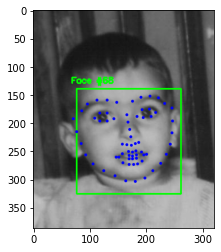

In [97]:


for img in imgs: 
    rects = detector(img_gray, 1)
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(img_gray, rect)

        coords = np.zeros((68,2), dtype="int")
        for i in range(0,68):
            coords[i] = (shape.part(i).x, shape.part(i).y)

        shape = coords
        # convert dlib's rectangle to a OpenCV-style bounding box
        # # [i.e., (x, y, w, h)], then draw the face bounding box
        x = rect.left()
        y = rect.top()
        w = rect.right() - x
        h = rect.bottom() - y

        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # show the face number
        cv2.putText(img_rgb, "Face #{}".format(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(img_rgb, (x, y), 1, (0, 0, 255), 2)
# show the output image with the face detections + facial landmarks
plt.imshow(img_rgb, cmap='gray')

points = read_pts('points/001a02.pts')
# for x, y in points:
#     cv2.circle(img, (int(x),int(y)), 1, (255,0,0), 2)
# plt.imshow(img, cmap='gray')

In [17]:
imageFileNames = os.listdir('images')
ages = [int(imageFileName.split('.')[0][4:6]) for imageFileName in imageFileNames] 

y_train = [] 
for age in ages: 
    if 0 <= age and age <= 2:
        y_train.append("0-2")
    elif 4 <= age and age <= 6:
        y_train.append("4-6")
    elif 8 <= age and age <= 13:
        y_train.append("8-13")
    elif 15 <= age and age <= 20:
        y_train.append("15-20")
    elif 25 <= age and age <= 32:
        y_train.append("25-32")
    elif 38 <= age and age <= 43:
        y_train.append("38-43")
    elif 48 <= age and age <= 53:
        y_train.append("48-53")
    elif 60 <= age:
        y_train.append("60+")

(0.0, 160.0)

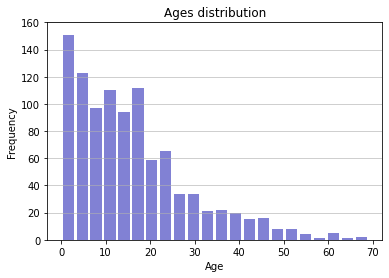

In [41]:
n, bins, patches = plt.hist(x=ages, bins='auto', color='#0504aa',alpha=0.5,rwidth=0.8)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Ages distribution')
maxfreq = n.max()

plt.ylim(ymax=np.ceil(maxfreq/10) * 10 if maxfreq % 10 else maxfreq + 10)

# Commonly used Augmentation Techniques 
Some of the commonly used Image data augmentations techniques are:

* Flipping 
This means flipping the image horizontally or vertically
* Rotation 
This means to rotate the image by a given angle in the clockwise or anticlockwise direction
* Cropping 
During cropping, a section of the image is sampled randomly
* Brightness 
Increase or decrease the brightness of the image
* Scaling
Scaling Images can be scaled outward or inward. When scaled outward, the image size increases while the image size decreases when scaled inwards.
* Noise Addition
We can also add gaussian noise to the existing images.


Documentation of imgaug : https://pythonrepo.com/repo/aleju-imgaug-python-computer-vision#installation

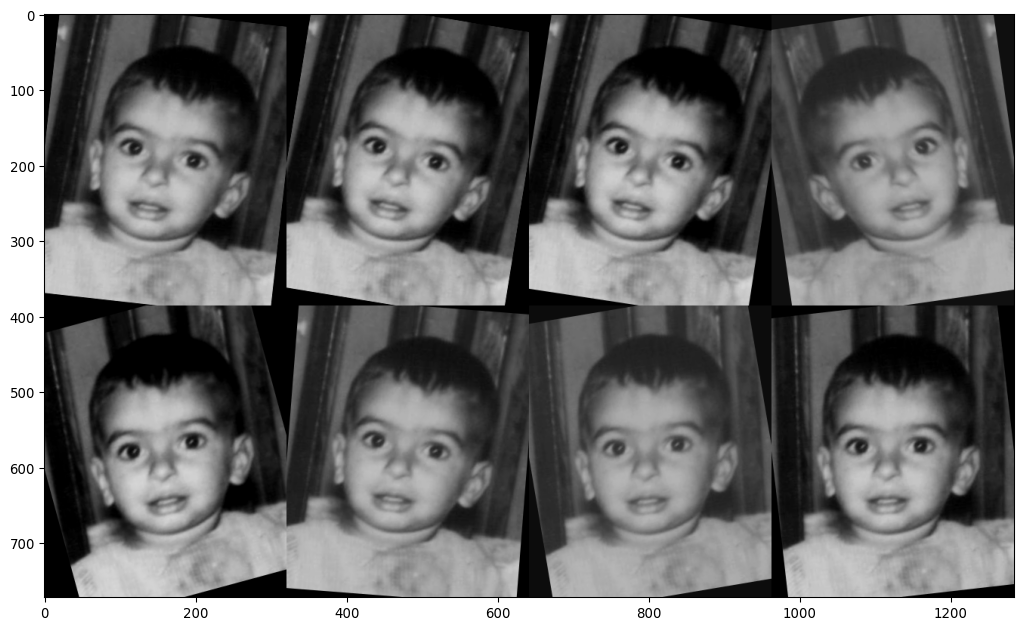

In [66]:

# BATCH_SIZE = 16 
# NB_BATCHES = 100

# batches = [UnnormalizedBatch(images=img) for _ in range(NB_BATCHES)]

# Example of Image Augmentation
ia.seed(218116689)

aug = iaa.Sequential([
    iaa.Affine(
        rotate=(-25, 25),
        shear=(-8,8),
    ),    
    iaa.Fliplr(0.5), # horizontal flips
    iaa.LinearContrast((0.75,1.5)),
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0,0.5))
    ),
], random_order=True) # apply augmenters in random order

images_aug = [aug(image=img) for _ in range(8)]
# plt.imshow(images_aug[0])
ia.imshow(ia.draw_grid(images_aug, cols=4, rows=2))

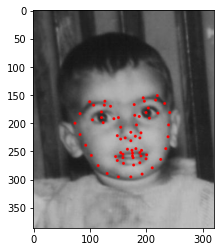

In [33]:
plt.imshow(img, cmap='gray')